In [1]:
import os

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential

In [2]:
# Konstante
normal = 0

# Versuchsparameter
training_data_ratio = 80 # in percent, remaining data will be test data
Prozent = 5
num_anomaly = 4
dataset_str = 'torque_l800_s2'

# automatisch generiert
classes = [0,1,2,3,4]#list(range(num_anomaly+1))
percentage = Prozent/100
model_str = f'vae0-{num_anomaly}p{Prozent}u.hdf5'

# get the working directory of the ipykernel
working_dir = os.getcwd()

# define subdirectories
data_path = os.path.join(working_dir, "data")
xy_path = os.path.join(data_path, dataset_str)

print(model_str)
print(dataset_str)

vae0-4p5u.hdf5
torque_l800_s2


In [3]:
def aursad(classes=classes):
    
    x = np.load(os.path.join(xy_path, "x.npy"))
    y = np.load(os.path.join(xy_path, "y.npy"))
    sample_nr = np.load(os.path.join(xy_path, "sample_nr.npy"))
    
    # extract the relevant classes only
    mask = [i in classes for i in y]
    x = x[mask,:,:]
    y = y[mask]
    
    # split dataset into training and test data
    split = len(y) * training_data_ratio // 100
  
    rng = np.random.default_rng(0)
    
    idx = np.arange(len(y))
    rng.shuffle(idx)
    
    train_idx = idx[:split]
    test_idx = idx[split:]
    
    x_train = x[train_idx,::]
    x_test = x[test_idx,::]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    return (x_train, y_train), (x_test, y_test)

def prepare_curves(raw):
    """dummy method"""   
    return raw

def unsupervised(dataset="train", percentage=percentage, batch_size=64, max_size=None):
    
    x = y = None
    if (dataset == "train"):
        (x, y), (_, _) = aursad()
    elif (dataset == "test"):
        (_,_), (x,y) = aursad()
    else:
        raise ValueError("Invalid dataset specified")
        
    num_normal_samples = np.sum(y == normal)
    p = percentage * num_normal_samples / (len(y)-num_normal_samples)
    rand = np.random.rand(len(y))
   
    mask = np.logical_or(y == normal, p > rand)
    x = prepare_curves(x)[mask,:,:]
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:]
    y = y[mask][:n]
    
    if max_size is not None:
        x = x[:max_size,:,:,:]
        y = y[:max_size]      
        
    return x, y
"""
def semi_supervised(dataset = "train", normal = normal, batch_size = 128, max_size = None):
    
    x = y = None
    if (dataset == "train"):
        (x, y), (_, _) = mnist()
    elif (dataset == "test"):
        (_,_), (x,y) = mnist()
    else:
        raise ValueError("Invalid dataset specified")
    
    x = prepare_images(x)[y == normal,:,:,:]
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:,:]
    y = y[y == normal][:n]
    
    if max_size is not None:
        x = x[:max_size,:,:,:]
        y = y[:max_size]      
        
    return x, y

def supervised(dataset = "train", batch_size = 128, max_size = None):
    x = y = None
    if (dataset == "train"):
        (x, y), (_, _) = mnist()
    elif (dataset == "test"):
        (_,_), (x,y) = mnist()
    else:
        raise ValueError("Invalid dataset specified")
    
    x = prepare_images(x)
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:,:]
    y = y[:n]
    
    if max_size is not None:
        x = x[:max_size,:,:,:]
        y = y[:max_size]   
    
    return x, y
"""

(x_peek, _), (_, _) = aursad()
sequence_length = x_peek.shape[1]
num_features = x_peek.shape[2]

print(f'Sequence length = {sequence_length}')
print(f'Number of features = {num_features}')

print(len(unsupervised(percentage=percentage)[0]))
print(len(aursad()[0][1]))

Sequence length = 800
Number of features = 1
1152
1632


In [1]:
latent_dim = 2
batch_size = 64
epochs = 10
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    #return tf.math.reduce_sum(keras.losses.binary_crossentropy(y_true, y_pred), axis=-1)
    return tf.reduce_mean(
        tf.reduce_sum(keras.losses.binary_crossentropy(y_true, y_pred), axis = (1,2)))

def nll2(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    return tf.reduce_sum(keras.losses.mean_squared_error(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = -0.5 * tf.reduce_sum(1 + log_var -
                                tf.square(mu) -
                                tf.exp(log_var))#, axis=-1)
        
        kl_div_loss = kl_batch#tf.reduce_mean(kl_batch)

        self.add_loss(kl_div_loss)
        self.add_metric(kl_div_loss, "KL-Div")

        return inputs
    
class ReconstructionLossLayer(Layer):
    
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(ReconstructionLossLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        original, reconstruction = inputs
        
        loss = nll2(original, reconstruction)
        
        reco_loss = tf.reduce_mean(loss)

        self.add_loss(reco_loss)
        self.add_metric(reco_loss, "Reconstr.Loss")

        return loss
    
class SampleLayer(Layer):
    
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(SampleLayer, self).__init__(*args, **kwargs)
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        #print(z_size, type(z_size))
        #assert z_size == latent_dim
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

# feature filters multiplier: considers multivariate data
ff = 1
if num_features > 2:
    ff = num_features // 2 
    
"""
decoder = Sequential([    
    Dense(11 * 64, input_dim=latent_dim, activation="relu"),
    layers.Reshape((11, 64)),
    layers.UpSampling1D(size=3),
    layers.Conv1DTranspose(filters=32, kernel_size=9, activation="relu"),
    layers.UpSampling1D(size=3),
    layers.Conv1DTranspose(filters=16, kernel_size=9, activation="relu"),
    layers.UpSampling1D(size=3),
    layers.Conv1DTranspose(filters=8, kernel_size=5, activation="relu"),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(filters=1, kernel_size=7, activation="sigmoid"),
], name = "Decoder")
"""

decoder = Sequential([    
    Dense(30 * 16, input_dim=latent_dim, activation="relu"),
    layers.Reshape((30,16)),
    layers.Conv1DTranspose(filters=16*ff, kernel_size=5, strides=2, padding="valid", activation="relu"),
    layers.Conv1DTranspose(filters=32*ff, kernel_size=5, strides=2, activation="relu"),
    layers.Conv1DTranspose(filters=64*ff, kernel_size=8, strides=2, activation="relu"),
    #layers.BatchNormalization(axis=1),
    layers.Conv1DTranspose(filters=num_features, kernel_size=9, strides=3, padding="valid", output_padding=0, activation="relu"),
], name = "Decoder")

encoder_input = keras.Input(shape=(sequence_length, num_features), name = "encoder-input")

encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=64*ff, kernel_size=9, strides=3, activation="relu"),
    keras.layers.Conv1D(filters=32*ff, kernel_size=7, strides=2, activation="relu"),
    keras.layers.Conv1D(filters=16*ff, kernel_size=5, strides=2, activation="relu"),
    keras.layers.Conv1D(filters=16*ff, kernel_size=5, strides=2, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation="relu"),
], name="Encoder")

"""
encoder = Sequential([
    layers.Conv1D(filters=8, kernel_size=7, activation="relu"),
    layers.MaxPool1D(pool_size=3),
    layers.Conv1D(filters=16, kernel_size=7, activation="relu"),
    layers.MaxPool1D(pool_size=3),
    layers.Conv1D(filters=32, kernel_size=5, activation="relu"),
    layers.MaxPool1D(pool_size=3),
    layers.Conv1D(filters=64, kernel_size=5, activation="relu"),
    layers.MaxPool1D(pool_size=3),
    layers.Flatten(),
    layers.Dense(16, activation="relu"),
], name="Encoder")
"""

"""
encoder_input = keras.Input(shape=(sequence_length, num_features), name = "encoder-input")
x = layers.Conv1D(filters=8, kernel_size=7, activation="relu")(encoder_input)
x = layers.MaxPool1D(pool_size=3)(x)
x = layers.Conv1D(filters=16, kernel_size=7, activation="relu")(x)
x = layers.MaxPool1D(pool_size=3)(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.MaxPool1D(pool_size=3)(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.MaxPool1D(pool_size=3)(x)
x = layers.Flatten()(x)
h = layers.Dense(16, activation="relu")(x)
"""

h = encoder(encoder_input)

z_mu = Dense(latent_dim, name="encoder-dense-mu")(h)
z_log_var = Dense(latent_dim, name ="encoder-dense-logvar")(h)

z_mu, z_log_var = KLDivergenceLayer(name="KLDivergence")([z_mu, z_log_var])

z = SampleLayer()([z_mu, z_log_var])

x_pred = decoder(z)

score = ReconstructionLossLayer()([encoder_input, x_pred])

vae = Model(inputs=encoder_input, outputs=score, name="vae-model")
vae.compile(optimizer="adam")
vae.summary()

NameError: name 'Layer' is not defined

In [5]:
# train the VAE on MNIST digits
training_data, _ = unsupervised()
print(training_data.shape)

callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = model_str, 
        save_weights_only = False,
        save_best_only = False)]

#vae.load_weights(model_str)
history = vae.fit(training_data, epochs=40, shuffle = True, batch_size=batch_size, callbacks = callbacks)
        #validation_data=(validation_data, validation_data)
#vae.load_weights(model_str)

(1152, 800, 1)
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-07-20 11:09:44.866299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-20 11:09:44.866440: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - 1s 36ms/step - loss: 24.2803 - KL-Div: 0.1156 - Reconstr.Loss: 20.9096
Epoch 2/40
18/18 [==============================] - 1s 36ms/step - loss: 15.5971 - KL-Div: 0.0064 - Reconstr.Loss: 15.5272
Epoch 3/40
18/18 [==============================] - 1s 36ms/step - loss: 14.8198 - KL-Div: 0.0039 - Reconstr.Loss: 14.4732
Epoch 4/40
18/18 [==============================] - 1s 36ms/step - loss: 14.4966 - KL-Div: 0.0700 - Reconstr.Loss: 13.3579
Epoch 5/40
18/18 [==============================] - 1s 36ms/step - loss: 12.9304 - KL-Div: 0.2947 - Reconstr.Loss: 12.7539
Epoch 6/40
18/18 [==============================] - 1s 34ms/step - loss: 12.7405 - KL-Div: 0.3609 - Reconstr.Loss: 12.4977
Epoch 7/40
18/18 [==============================] - 1s 34ms/step - loss: 12.4866 - KL-Div: 0.4116 - Reconstr.Loss: 12.2724
Epoch 8/40
18/18 [==============================] - 1s 34ms/step - loss: 12.9724 - KL-Div: 0.4558 - Reconstr.Loss: 12.1807
Epoch 9/40
18/18 [=========

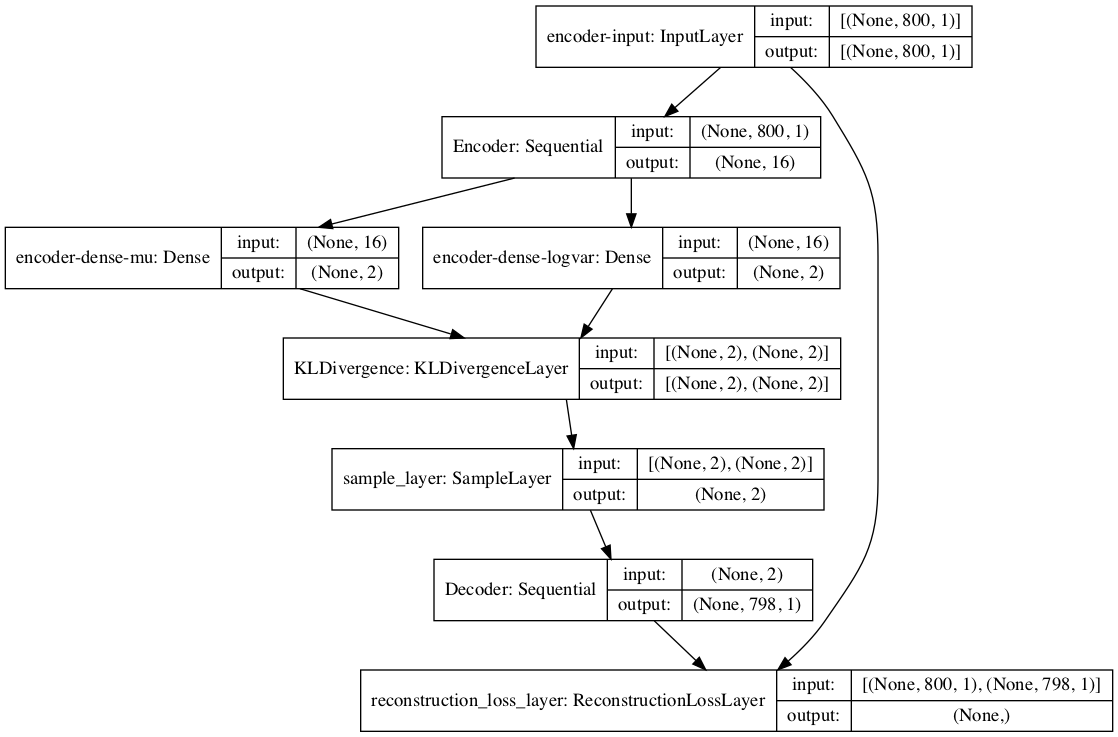

In [6]:
keras.utils.plot_model(vae, show_shapes = True)

### Aktives Lernen - Entkoppelter Ansatz
Der Klassifikator wird auf den Ausgaben des Encoders trainiert, ohne dass die Parametrierung des Encoders im Laufe des Trainings angepasst wird

In [7]:
#mu_input = Input(shape=(latent_dim))
#log_var_input = Input(shape=(latent_dim))

#vae_al_input = layers.Concatenate()([mu_input, log_var_input])
#hidden = Dense(8, activation = "relu")(vae_al_input)
#hidden = Dense(8, activation = "relu")(hidden)
#y_pred = Dense(1, activation = "sigmoid")(hidden)

#vae_al = Model(inputs = [mu_input, log_var_input], outputs=y_pred, name="vae-active-learning")
#vae_al.compile(optimizer="adam", loss="binary_crossentropy")
#vae_al.summary()

### Aktives Lernen - Rückkopplung zum Encoder
Der Klassifikator wird als weitere Schicht auf den Encoder aufgesetzt und beeinflusst so dessen Parameter während des Trainings

In [8]:
#vae_al_input = layers.Concatenate()([z_mu, z_log_var])
#hidden = Dense(8, activation = "relu")(vae_al_input)
#hidden = Dense(8, activation = "relu")(hidden)
#y_pred = Dense(1, activation = "sigmoid")(hidden)

#vae_al = Model(inputs = encoder_input, outputs=y_pred, name="vae-active-learning")
#vae_al.compile(optimizer="adam", loss="binary_crossentropy")
#vae_al.summary()

### Aktives Lernen - Feedback für das Gesamtmodell
Im unüberwachten Szenario ist der Verlust unverändert, im überwachten Szenario wird auf den Verlus der BinaryCrossEntropyLoss des Klassifikator aufaddiert

In [9]:
score_scaled = layers.Lambda(lambda x: x*0/100, name="score-scaling")(score)
score_vec = layers.Reshape((1,))(score_scaled)
interface = layers.Concatenate()([z_mu, z_log_var, score_vec])
hidden = Dense(8, activation = "relu")(interface)
hidden = Dense(8, activation = "relu")(hidden)
y_pred = Dense(1, activation = "sigmoid")(hidden)

vae_al = Model(inputs=encoder_input, outputs=y_pred, name="vae-active-learning")
vae_al.compile(optimizer="adam", loss="binary_crossentropy")
#vae_al.summary()

In [10]:
#keras.utils.plot_model(vae_al, show_shapes = True)

In [11]:
vae_encoder = Model(inputs = encoder_input, outputs = [z_mu, z_log_var])
#keras.utils.plot_model(encoder)

408
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
70.539024
162.18019
2.5319405


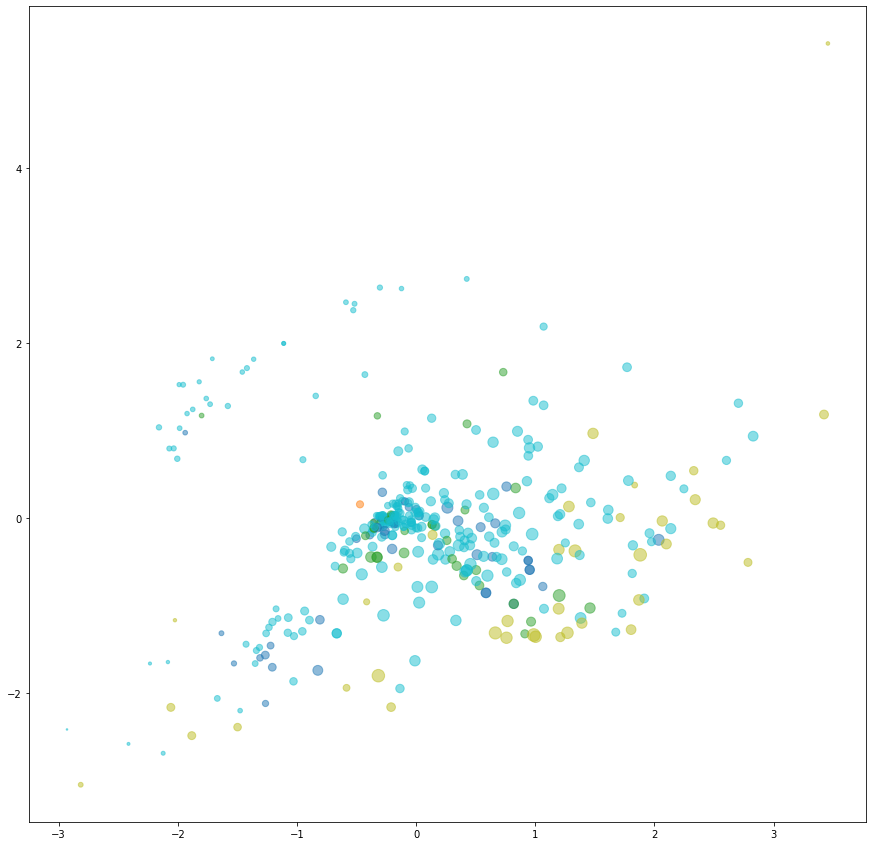

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_latent_space(vae, include_labels=[i for i in range(10)], show_size = True):
    
    (_, _), (x_test, y_test) = aursad()
    #(x_test, y_test), (_, _) = aursad()
    print(len(y_test))
    
    encoder = Model(inputs = encoder_input, outputs = [z_mu, z_log_var])
    
    def color_from_label(labels):
        l2c = {0:'tab:cyan',
               1:'tab:blue',
               2:'tab:green',
               3:'tab:olive',
               4:'tab:orange',
               5:'tab:red',
               6:'tab:brown',
               7:'tab:purple',
               8:'tab:pink',
               9:'tab:gray',
              }
        return [l2c[label] for label in labels]
    
    idx = [i in include_labels for i in y_test]
    
    l = len(idx) // batch_size
    
    x = prepare_curves(x_test)[idx,:,:][:batch_size*l,::]
    labels = y_test[idx][:batch_size*l]
    z = encoder.predict_on_batch(x)
    latent_x = z[0][:,0]
    latent_y = z[0][:,1]
    latent_size = 10
    if show_size:
        latent_size = np.mean(np.exp(z[1]),axis = 1) * 300
    
    print(np.mean(latent_size))
    print(np.max(latent_size))
    print(np.min(latent_size))
    
    plt.figure(figsize=(15,15))
    plt.scatter(latent_x, latent_y, s=latent_size, c=color_from_label(labels), alpha=0.5)
    
"""
    # Display a 2D manifold of the digits
    n = 16  # figure with 10x10 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    grid_x = np.linspace(min(latent_x), max(latent_x), n)
    grid_y = np.linspace(min(latent_y), max(latent_y), n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(15, 15))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.axis("off")
    plt.imshow(figure, cmap="Greys_r")  
    """
    
visualize_latent_space(None)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

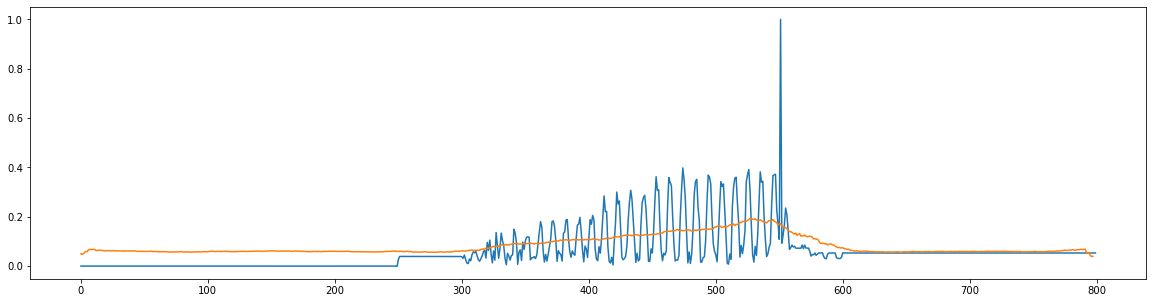

In [13]:
def reconstruction(sample=0, feature=0):
    
    (orig, _), (_, _) = aursad()

    orig = orig[sample,:,:]
     
    fig = plt.figure(figsize=(20,5))
    
    plt.plot(orig[:,feature])
    z = vae_encoder.predict(orig.reshape((1,sequence_length,num_features)))[0]
    decoded = decoder.predict(z)
    plt.plot(decoded.reshape((-1,num_features))[:,feature])
    plt.show()


reconstruction()

In [14]:
def load_vae(path):
    mapping = {
        "KLDivergenceLayer": KLDivergenceLayer,
        "SampleLayer": SampleLayer,
        "ReconstructionLossLayer": ReconstructionLossLayer,
    }
    vae = keras.models.load_model(path, custom_objects = mapping)
    return vae

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18.61307344436642
(1152, 800, 1)
1152


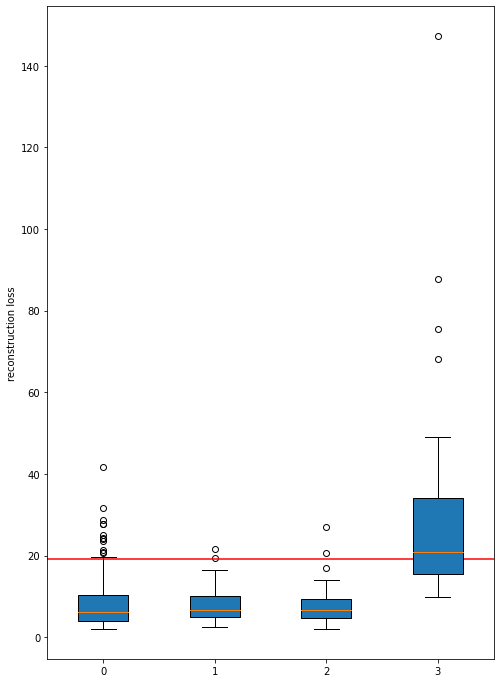

In [15]:
def anomaly_detection(vae):
    
    (_, _), (x_test, y_test) = aursad()
    #(x_test, y_test), (_, _) = mnist()
    
    def color_from_label(labels):
        l2c = {0:'tab:cyan',
               1:'tab:blue',
               2:'tab:green',
               3:'tab:olive',
               4:'tab:orange',
               5:'tab:red',
               6:'tab:brown',
               7:'tab:purple',
               8:'tab:pink',
               9:'tab:gray',
              }
        return [l2c[label] for label in labels]
    
    labels = [i for i in range(4)]
    
    all_loss = list()   
    for label in labels:
        x = prepare_curves(x_test)[y_test == label,:,:][:1024,:,:]
        if x.shape[0] == 0:
            all_loss.append([0])
            continue
        loss = vae.predict(x)
        
        if label == normal:
            print(np.quantile(loss, 0.95))
        all_loss.append(loss)
    
    fig, ax = plt.subplots(figsize=(8,12))
    ax.boxplot(all_loss,
        vert=True,  # vertical box alignment
        patch_artist=True,  # fill with color
        labels=labels)
    ax.set_ylabel("reconstruction loss")
    
    x_train, _ = unsupervised(dataset = "train")
    print(x_train.shape)
    loss = vae.predict(x_train)
    print(len(loss))
    critical_anomaly_score = np.quantile(loss, 0.95)
    
    ax.axhline(critical_anomaly_score, color="r")

#my_vae = load_vae(model_str)
anomaly_detection(vae)

In [16]:
#vae.save("vae1.hdf5")
#vae.save_weights("vae1weights.hdf5")

In [17]:
def baseline_ad(model = "unsupervised"):
    baseline_model = load_vae(model_str)
    
    x_train_normal = None
    if model == "unsupervised":
        x_train_normal, _ = unsupervised(dataset = "train")
    else:
        #x_train_normal, _ = semi_supervised(dataset = "train", normal = normal)
        assert False
    loss = baseline_model.predict(x_train_normal)
    critical_anomaly_score = np.quantile(loss, 0.90)
    
    print(f'Critical Anomaly Score = {critical_anomaly_score}')
    
    (_,_), (x_test, y_test) = aursad()
    
    for i in range(5):
        count = np.sum(y_test==i)
        print(f'Anzahl {i}: {count}')
    
    score = baseline_model.predict(x_test)
    
    predicted = score > critical_anomaly_score
    actual = y_test != 0
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(y_test)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
    
baseline_ad()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Critical Anomaly Score = 15.982474899291994
Anzahl 0: 284
Anzahl 1: 45
Anzahl 2: 37
Anzahl 3: 41
Anzahl 4: 1
TP = 38, TN = 261, FP = 23, FN = 86, N = 408
Accuracy = 0.7328431372549019, F1 = 0.41081081081081083, precision = 0.6229508196721312, recall = 0.3064516129032258


### Query Strategy

In [18]:
def naive_query(budget, normal = 0):
    x_query, y_query = supervised(dataset = "train", max_size = budget)
    y_query = y_query != normal     
    return x_query, y_query
    
def edgecase_query(budget, normal = 0):
    x, y = unsupervised(dataset = "train", max_size = None)
    y = y != normal
    
    baseline_model = load_vae(model_str)
    loss = baseline_model.predict(x)
    critical_anomaly_score = np.quantile(loss, 0.90)    
    print(f'Critical Anomaly score: {critical_anomaly_score}')
        
    edge_cases = np.abs(loss - critical_anomaly_score)
        
    idx = np.argsort(edge_cases)
    idx = idx[:budget]
        
    return x[idx, :,:,:], y[idx]
    
    
def edgecase_query_plus(budget, normal = 0):
    x, y = unsupervised(dataset = "train", max_size = None)
    y = y != normal
    
    baseline_model = load_vae(model_str)
    loss = baseline_model.predict(x)
    critical_anomaly_score = np.quantile(loss, 0.90)    
    print(f'Critical Anomaly score: {critical_anomaly_score}')
        
    edge_cases = loss - critical_anomaly_score
        
    # reduce x and y
    x = x[edge_cases > 0]
    y = y[edge_cases > 0]
    edge_cases = edge_cases[edge_cases > 0] # only select more anomalous examples
        
    idx = np.argsort(edge_cases)
    idx = idx[:budget]
        
    return x[idx, :,:,:], y[idx]
    
def most_anomalous_query(budget, normal = 0):
    x, y = unsupervised(dataset = "train", max_size = None)
    y = y != normal
    
    baseline_model = load_vae(model_str)
    loss = baseline_model.predict(x)
        
    idx = np.argsort(loss)
    idx = idx[-budget:]
        
    return x[idx, :,:,:], y[idx]

In [19]:
def active_learning_decoupled(normal = 0):
    """Enhance the prediction accuracy by retraining the model with the top-k most intersting samples in a
    supervised fashion.
        1) Find the top-k samples and get their labels
        2) Retrain the model with these samples in a supervised fashion -> prevent overfitting
        3) Evaluate accuracy, F1-score, ..."""
    
    budget = batch_size  
    
    x_query, y_query = most_anomalous_query(budget)
    print(np.sum(y_query))
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = 'vae_al0-{epoch:02d}.hdf5', 
        save_weights_only = False,
        save_best_only = False)]
    
    z_query = encoder.predict(x_query)

    history = vae_al.fit(z_query, y_query, shuffle = True, epochs=100, batch_size=32)
        #training_data,
        #shuffle=True,      
     #   callbacks = callbacks,
      #  validation_data = (x_valid, y_valid))
    
    x_test, y_test = supervised(dataset = "test")
    z_test = encoder.predict(x_test)
    
    predicted = vae_al.predict(z_test).reshape((-1)) > 0.5
    actual = y_test != normal
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(y_test)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
#active_learning_decoupled()

In [20]:
def active_learning_encoderfeedback(normal = 0):
    budget = batch_size  
    
    x_query, y_query = most_anomalous_query(budget)
    print(np.sum(y_query))
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = 'vae_al_ef0-{epoch:02d}.hdf5', 
        save_weights_only = False,
        save_best_only = False)]

    history = vae_al.fit(x_query, y_query, shuffle = True, epochs=50, batch_size=32)
    
    x_test, y_test = supervised(dataset = "test")
    
    predicted = vae_al.predict(x_test).reshape(-1) > 0.5
    actual = (y_test != normal)
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
#active_learning_encoderfeedback()

In [21]:
def active_learning_modelfeedback(normal = 0):
    budget = batch_size 
    
    x_query, y_query = most_anomalous_query(budget)
    print(np.sum(y_query))
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = 'vae_al_ef0-{epoch:02d}.hdf5', 
        save_weights_only = False,
        save_best_only = False)]

    history = vae_al.fit(x_query, y_query, shuffle = True, epochs=60, batch_size=32)
    
    x_test, y_test = supervised(dataset = "test")
    
    predicted = vae_al.predict(x_test).reshape(-1) > 0.5
    actual = (y_test != normal)
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(actual)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
active_learning_modelfeedback()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [ ]:
visualize_latent_space(None, show_size = True)
anomaly_detection(vae)